In [150]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
from yahooquery import Ticker
import time

In [151]:
#importando base
df_ibrx = pd.read_excel(r'C:\Users\drsan\OneDrive\Área de Trabalho\Python\ETFs_Onshore.xlsx',sheet_name = 'IBRX100')
df_ibrx.head()

,Código,Ação,Tipo,Qtde. Teórica,Part. (%),Setor,Subsetor,Segmento
0,ABEV3,AMBEV S/A,ON,4.354.228.928,2936.0,Consumo não Cíclico,Bebidas,Cervejas e Refrigerantes
1,ALPA4,ALPARGATAS,PN N1,187.007.704,328.0,Consumo Cíclico,"Tecidos, Vestuário e Calçados",Calçados
2,ALSO3,ALIANSCSONAE,ON NM,127.374.163,186.0,Financeiro,Exploração de Imóveis,Exploração de Imóveis
3,AZUL4,AZUL,PN N2,317.471.474,363.0,Bens Industriais,Transporte,Transporte Aéreo
4,B3SA3,B3,ON NM,2.046.021.644,6301.0,Financeiro,Serviços Financeiros Diversos,Serviços Financeiros Diversos


In [152]:
# dando aquele tapa
df = df_ibrx
df = pd.DataFrame(df) 
df = df.dropna()
df['Part. (%)'] /= 100000
df.rename(columns={'Código\xa0':'Codigo'}, inplace = True)
df['Codigo'] = df['Codigo'] + ".SA"
tickers = df['Codigo']

In [153]:
#auxiliares estrategias
def stochastic(x,a,b):
    # x = matriz de precos
    # a = periodo stochastic
    # b = signal
    df = x.copy()
    df['%K'] = (df['Close']-df['Low'].rolling(a).min())/(df['High'].rolling(a).max()-df['Low'].rolling(a).min())*100
    df['%D'] = df['%K'].rolling(b).mean()
    return df

def MACD(x,a,b,c):
    # x = matriz de precos
    # a = fast mov avg
    # b = slow mov avg
    # c = signal
    df = x.copy()
    df['MACD'] = df['Close'].ewm(span=a).mean() - df['Close'].ewm(span=b).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=c).mean()
    return df

def SMA(x,a,b):
    # x = matriz de precos
    # a = fast mov avg
    # b = slow mov avg
    df = x.copy()
    df['SMA_Fast'] = df['Close'].rolling(a).mean()
    df['SMA_Slow'] = df['Close'].rolling(b).mean()
    return df

def EMA(x,a,b):
    # x = matriz de precos
    # a = fast mov avg
    # b = slow mov avg
    df = x.copy()
    df['EMA_Fast'] = df['Close'].ewm(span=a).mean()
    df['EMA_Slow'] = df['Close'].ewm(span=b).mean()
    return df

In [154]:
def trades(x,y):
    # x = matriz de precos com trade_signal
    # y e o ativo
    df = x.copy()
    df_trades = pd.DataFrame(columns=['ativo','data_entrada','preco_entrada','data_saida','preco_saida','periodos'])
    ativo = y
    
    for i in range(len(df)):
        
        if i == 0:
            if df['trade_signal'][i] == 'Buy':
                data_entrada = df.index[i]
                preco_entrada = df['Close'][i]
                contador = i
                                        
        elif df['trade_signal'][i-1] == '' and df['trade_signal'][i] == 'Buy':          
            data_entrada = df.index[i]
            preco_entrada = df['Close'][i]
            contador = i
            
        elif df['trade_signal'][i-1] == 'Buy' and df['trade_signal'][i] == '':
            data_saida = df.index[i]
            preco_saida = df['Close'][i]
            periodos = i - contador
            df_trades.loc[len(df_trades)] = [ativo,data_entrada,preco_entrada,data_saida,preco_saida,periodos]
    
    df_trades['return'] = df_trades['preco_saida']/df_trades['preco_entrada'] - 1
    return df_trades

In [155]:
def trades_KPIs(x):
    # x = matriz de trades 
    df = x.copy()
    df_KPIs = pd.DataFrame({'return':[df['return'].mean()]})
    
    #return
    #df_KPIs['return'] = df['return'].mean()
    df_KPIs['vol'] = df['return'].std()
    df_KPIs['sharpe'] = df_KPIs['return']/df_KPIs['vol']
    
    #trades
    df_KPIs['qtd_trades'] = len(df)
    df_KPIs['win_trades'] = len(df[df['return']>0])
    df_KPIs['win_ratio'] = df_KPIs['win_trades'] / df_KPIs['qtd_trades']
    df_KPIs['avg_duration'] = df['periodos'].mean()
    
    #avg ratios
    df_KPIs['avg_win'] = df[df['return']>0]['return'].mean()
    df_KPIs['avg_loss'] = df[df['return']<=0]['return'].mean()
    df_KPIs['avg_win_vs_loss'] = df_KPIs['avg_win']/abs(df_KPIs['avg_loss'])
    df_KPIs['top_win'] = df[df['return']>0]['return'].max()
    df_KPIs['top_loss'] = df[df['return']<=0]['return'].min()

    return df_KPIs

In [156]:
def trade_signal(x):
    # x = matriz de precos
    df = x.copy()
    df = stochastic(EMA(SMA(df,5,20),5,20),20,3)
    df['trade_signal'] = ''
    df['return'] = float(0)
    
    for i in range(len(df)):
        
        if df['trade_signal'][i-1] == '':
            if df['Close'][i] > df['EMA_Fast'][i] and df['Close'][i] < df['SMA_Slow'][i] and \
            df['%K'][i] < 30:
                df['trade_signal'][i] = 'Buy'
        
        if df['trade_signal'][i-1] == "Buy":
            df['return'][i] = df['Close'][i] / df['Close'][i-1] - 1
            if df['Close'][i] <= df['EMA_Fast'][i] or df['Close'][i] >= df['SMA_Slow'][i] or \
            df['%K'][i] > 50:
                df['trade_signal'][i] = ''
            else:
                df['trade_signal'][i] = 'Buy'
              
    return df

In [157]:
def trade_signal_MODELO(x):
    # x = matriz de precos
    df = x.copy()
    df = stochastic(SMA(df,5,20),5,3)
    df['trade_signal'] = ''
    df['return'] = float(0)
    
    for i in range(len(df)):
        
        if df['trade_signal'][i-1] == '':
            if df['SMA_Fast'][i] > df['SMA_Slow'][i] and df['Close'][i] > df['SMA_Fast'][i] and \
            df['%K'][i] >= df['%D'][i] and df['%K'][i] < 30:
                df['trade_signal'][i] = 'Buy'
        
        if df['trade_signal'][i-1] == "Buy":
            df['return'][i] = df['Close'][i] / df['Close'][i-1] - 1
            if df['SMA_Fast'][i] >= df['Close'][i] or \
            df['%K'][i] < df['%D'][i] or df['%K'][i] > 70:
                df['trade_signal'][i] = ''
            else:
                df['trade_signal'][i] = 'Buy'
              
    return df

In [158]:
start = dt.date.today() + dt.timedelta(1) - dt.timedelta(1080)
end = dt.date.today() + dt.timedelta(1)
prices = {}
interval = '1d' #1d para diario, 5m para 5minutos
for t in tickers:
    try:
        prices[t] = yf.download(t,start,end,interval)
    except: 
        continue
    prices[t].dropna(how='all', inplace = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [159]:
tickers2 = tickers[:]
portfolio = {}
df_trades = pd.DataFrame()
returns = pd.DataFrame()
for t in tickers2:
    print(t, "passthrough at ",time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    portfolio[t] = trade_signal(prices[t])
    df_trades = pd.concat([df_trades,trades(portfolio[t],t)])
    df_trades.reset_index(drop=True, inplace=True)
    returns[t] = portfolio[t]['return']

ABEV3.SA passthrough at  2020-09-03 20:56:16


C:\Users\drsan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\drsan\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\drsan\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\drsan\anaconda3\lib\site-packages\ipykernel_l

ALPA4.SA passthrough at  2020-09-03 20:56:16
ALSO3.SA passthrough at  2020-09-03 20:56:17
AZUL4.SA passthrough at  2020-09-03 20:56:17
B3SA3.SA passthrough at  2020-09-03 20:56:17
BBAS3.SA passthrough at  2020-09-03 20:56:17
BBDC3.SA passthrough at  2020-09-03 20:56:17
BBDC4.SA passthrough at  2020-09-03 20:56:17
BBSE3.SA passthrough at  2020-09-03 20:56:18
BEEF3.SA passthrough at  2020-09-03 20:56:18
BIDI11.SA passthrough at  2020-09-03 20:56:18
BPAC11.SA passthrough at  2020-09-03 20:56:18
BPAN4.SA passthrough at  2020-09-03 20:56:18
BRAP4.SA passthrough at  2020-09-03 20:56:18
BRDT3.SA passthrough at  2020-09-03 20:56:19
BRFS3.SA passthrough at  2020-09-03 20:56:19
BRKM5.SA passthrough at  2020-09-03 20:56:19
BRML3.SA passthrough at  2020-09-03 20:56:19
BRSR6.SA passthrough at  2020-09-03 20:56:19
BTOW3.SA passthrough at  2020-09-03 20:56:20
CCRO3.SA passthrough at  2020-09-03 20:56:20
CESP6.SA passthrough at  2020-09-03 20:56:20
CIEL3.SA passthrough at  2020-09-03 20:56:20
CMIG4.SA

In [160]:
trades_KPIs(df_trades)

,return,vol,sharpe,qtd_trades,win_trades,win_ratio,avg_duration,avg_win,avg_loss,avg_win_vs_loss,top_win,top_loss
0,0.000597,0.041676,0.014333,1515,522,0.344554,1.892409,0.042441,-0.021399,1.983315,0.403704,-0.21358


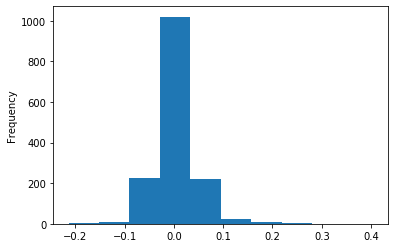

In [161]:
(df_trades['return']).plot.hist()

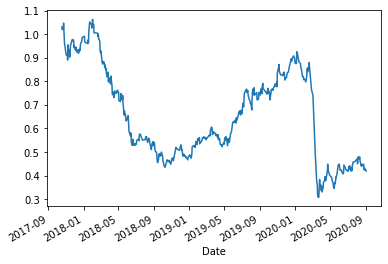

In [169]:
# matriz de retornos para grafico
returns['total'] = [returns.iloc[i][returns.iloc[i]!=0].mean() for i in range(len(returns))]
(returns['total'][returns['total'].isnull() == False]+1).cumprod().plot()

In [189]:
returns.iloc[:,:-1].sum(axis=1)[abs(returns.iloc[:,:-1].sum(axis=1))>1]

Date
2018-06-21   -1.020137
2020-03-25    3.068559
2020-03-26    3.698057
2020-03-27   -3.259742
2020-03-31   -1.258668
dtype: float64

In [163]:
#bovespa para comparacao
bench = pd.DataFrame()
bench = yf.download('BOVA11.SA',start,end,interval)['Close']

[*********************100%***********************]  1 of 1 completed


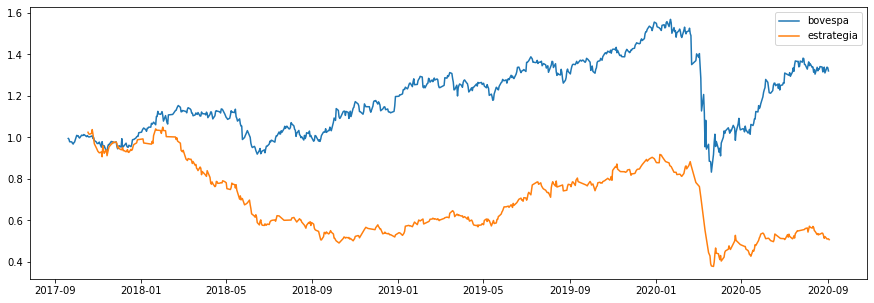

In [164]:
# grafico estrategia vs bovespa
plt.figure(figsize=(15,5))
plt.plot((bench.shift(-1)/bench).cumprod(), label ='bovespa')
plt.plot((returns['total'][returns['total'].isnull() == False]+1).cumprod(), label ='estrategia')
plt.legend()
plt.show()